<a href="https://colab.research.google.com/github/anjalii-s/Thesis-2026-/blob/main/Code_B_Taiwan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""Taiwan Credit Card Default – Rigorous Accuracy–Interpretability Study (Code B style)"""

# ============================================================
# 1. Install & Imports
# ============================================================
!pip install -q imbalanced-learn shap lightgbm xgboost seaborn scikit-learn pandas numpy matplotlib

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb, lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import shap

plt.style.use('default'); sns.set_palette("husl"); np.random.seed(42)

# ============================================================
# 2. Load & Preprocess Taiwan Dataset
# ============================================================
import kagglehub, os
path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")
csv_path = os.path.join(path, "UCI_Credit_Card.csv")
df = pd.read_csv(csv_path)

# Clean
df = df.drop(columns=['ID']) if 'ID' in df.columns else df
df.rename(columns={'default.payment.next.month': 'target'}, inplace=True)
df['target'] = df['target'].astype(int)

X = df.drop('target', axis=1)
y = df['target']

# Categorical & numeric
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE']
num_cols = [c for c in X.columns if c not in cat_cols]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

# ============================================================
# 3. Models & Samplers
# ============================================================
models = {
    'RF': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGB': xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42, eval_metric='logloss', n_jobs=-1),
    'LGB': lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42, verbose=-1, n_jobs=-1)
}

resamplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42),
    'Borderline': BorderlineSMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'Under': RandomUnderSampler(random_state=42),
    'CostSensitive': 'cost'
}

classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}

# ============================================================
# 4. Explanation Functions (same as Code B)
# ============================================================
def get_shap_reliable(pipe, X_test):
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)
        return sv[1] if isinstance(sv, list) else sv
    except:
        from sklearn.inspection import permutation_importance
        res = permutation_importance(clf, X_proc, pipe.predict(X_proc), n_repeats=3, random_state=42)
        return np.tile(res.importances_mean, (X_proc.shape[0], 1))

def compute_banzhaf(pipe, X_test, n_samples=5, max_instances=5):
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))
    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                coal = np.random.binomial(1, 0.5, n_feat)
                coal[f] = 0
                p0 = clf.predict_proba(x * coal.reshape(1, -1))[0, 1]
                coal[f] = 1
                p1 = clf.predict_proba(x * coal.reshape(1, -1))[0, 1]
                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat

feature_groups = {
    'Demographic': ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE'],
    'Limit': ['LIMIT_BAL'],
    'History': [c for c in X.columns if 'PAY_' in c],
    'Bill': [c for c in X.columns if 'BILL_AMT' in c],
    'Payment': [c for c in X.columns if 'PAY_AMT' in c]
}

def compute_owen(pipe, X_test, feature_groups, n_samples=3, max_instances=5):
    clf = pipe.named_steps['clf']; prep = pipe.named_steps['prep']
    X_proc = prep.transform(X_test)
    fnames = prep.get_feature_names_out()
    group_idx = {g: [i for i, n in enumerate(fnames) if any(f in n for f in feats)]
                 for g, feats in feature_groups.items()}
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))
    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                gmask = {g: np.random.choice([0,1]) for g in group_idx}
                mask = np.zeros(n_feat)
                for g, idxs in group_idx.items():
                    if gmask[g]:
                        if f in idxs:
                            for idx in idxs: mask[idx] = np.random.choice([0,1])
                        else: mask[idxs] = 1
                mask0 = mask.copy(); mask0[f] = 0
                p0 = clf.predict_proba(x * mask0)[0,1]
                p1 = clf.predict_proba(x * mask)[0,1]
                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat

# ============================================================
# 5. Metrics (identical to Code B)
# ============================================================
#
def stability_cv(expl_list):
    if len(expl_list) < 2:
        return 1.0
    arr = np.stack([np.abs(e) for e in expl_list])           # shape: (n_folds, n_samples, n_features)
    mean = arr.mean(axis=0) + 1e-8
    std = arr.std(axis=0)
    cv_per_feature = std / mean
    return float(np.mean(cv_per_feature))                    # scalar

def jaccard_topk(expl_list, k=5):
    if len(expl_list) < 2:
        return 0.0
    sets = []
    for exp in expl_list:
        # Mean absolute SHAP/value per feature across instances
        imp = np.abs(exp).mean(axis=0).ravel()
        # Get indices of top-k features → convert to tuple (hashable!)
        topk_indices = tuple(np.argsort(imp)[-k:].tolist())
        sets.append(topk_indices)

    # Pairwise Jaccard
    sims = []
    for i in range(len(sets)):
        for j in range(i + 1, len(sets)):
            inter = len(set(sets[i]) & set(sets[j]))
            union = len(set(sets[i]) | set(sets[j]))
            sims.append(inter / union if union > 0 else 0.0)
    return float(np.mean(sims)) if sims else 0.0

def interpretability_score(cv, j, beta=0.5):
    return beta * (1 - cv) + (1 - beta) * j

def normalize(s):
    return (s - s.min()) / (s.max() - s.min() + 1e-8)

def tradeoff_metric(auc_series, I_series, alpha=0.5):
    return alpha * normalize(auc_series) + (1-alpha) * normalize(I_series)

# ============================================================
# 6. 4-Fold CV Loop (the gold standard)
# ============================================================
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
records = []

for mname, model in models.items():
    for sname, sampler in resamplers.items():
        aucs = []
        shap_runs, banzhaf_runs, owen_runs = [], [], []

        for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))
            steps.append(('clf', model))
            pipe = ImbPipeline(steps)

            # Cost-sensitive
            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0]
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            pipe.fit(X_tr, y_tr)
            auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1])
            aucs.append(auc)
            print(f"Fold {fold} | {mname}+{sname:12} → AUC: {auc:.4f}")

            # Explanations on small sample
            X_sample = X_te.sample(n=min(50, len(X_te)), random_state=42)
            shap_runs.append(get_shap_reliable(pipe, X_sample))
            banzhaf_runs.append(compute_banzhaf(pipe, X_sample))
            owen_runs.append(compute_owen(pipe, X_sample, feature_groups))

        # Aggregate
        auc_mean = np.mean(aucs)
        for method, runs in zip(['SHAP','Banzhaf','Owen'], [shap_runs, banzhaf_runs, owen_runs]):
            cv_val = stability_cv(runs)
            jacc = jaccard_topk(runs)
            I = interpretability_score(cv_val, jacc)
            records.append({
                'Model': mname, 'Sampler': sname, 'Method': method,
                'AUC': auc_mean, 'CV': cv_val, 'Stability': 1-cv_val,
                'Jaccard': jacc, 'I': I
            })

# ============================================================
# 7. Results & Visualisations
# ============================================================
metrics = pd.DataFrame(records)
metrics['T(α=0.5)'] = tradeoff_metric(metrics['AUC'], metrics['I'])

print("\n=== TAIWAN DATASET – FINAL METRICS (4-fold CV) ===")
print(metrics.round(4).to_string(index=False))

# Average by method
print("\n=== Average by Explanation Method ===")
print(metrics.groupby('Method')[['AUC','Stability','Jaccard','I','T(α=0.5)']].mean().round(4))

# LaTeX tables (copy-paste into thesis)
for method in ['SHAP','Banzhaf','Owen']:
    subset = metrics[metrics['Method']==method]
    latex = subset[['Model','Sampler','AUC','Stability','Jaccard','I','T(α=0.5)']].round(4).to_latex(
        index=False, caption=f"Taiwan Dataset – {method} Results (4-fold CV)", label=f"tab:taiwan_{method.lower()}")
    print(f"\nLaTeX TABLE — {method}:\n{latex}")

# Summary table
summary = metrics.groupby('Method')[['AUC','Stability','Jaccard','I','T(α=0.5)']].mean().round(4)
print("\nSUMMARY LaTeX:\n", summary.to_latex(caption="Taiwan Dataset – Method Comparison", label="tab:taiwan_summary"))

Using Colab cache for faster access to the 'default-of-credit-card-clients-dataset' dataset.
Fold 1 | RF+None         → AUC: 0.7891
Fold 2 | RF+None         → AUC: 0.7756
Fold 3 | RF+None         → AUC: 0.7834
Fold 4 | RF+None         → AUC: 0.7724
Fold 1 | RF+SMOTE        → AUC: 0.7830
Fold 2 | RF+SMOTE        → AUC: 0.7665
Fold 3 | RF+SMOTE        → AUC: 0.7783
Fold 4 | RF+SMOTE        → AUC: 0.7707
Fold 1 | RF+Borderline   → AUC: 0.7805
Fold 2 | RF+Borderline   → AUC: 0.7636
Fold 3 | RF+Borderline   → AUC: 0.7758
Fold 4 | RF+Borderline   → AUC: 0.7689
Fold 1 | RF+ADASYN       → AUC: 0.7794
Fold 2 | RF+ADASYN       → AUC: 0.7630
Fold 3 | RF+ADASYN       → AUC: 0.7773
Fold 4 | RF+ADASYN       → AUC: 0.7676
Fold 1 | RF+SMOTEENN     → AUC: 0.7836
Fold 2 | RF+SMOTEENN     → AUC: 0.7662
Fold 3 | RF+SMOTEENN     → AUC: 0.7793
Fold 4 | RF+SMOTEENN     → AUC: 0.7708
Fold 1 | RF+SMOTETomek   → AUC: 0.7824
Fold 2 | RF+SMOTETomek   → AUC: 0.7668
Fold 3 | RF+SMOTETomek   → AUC: 0.7807
Fold 4 | R

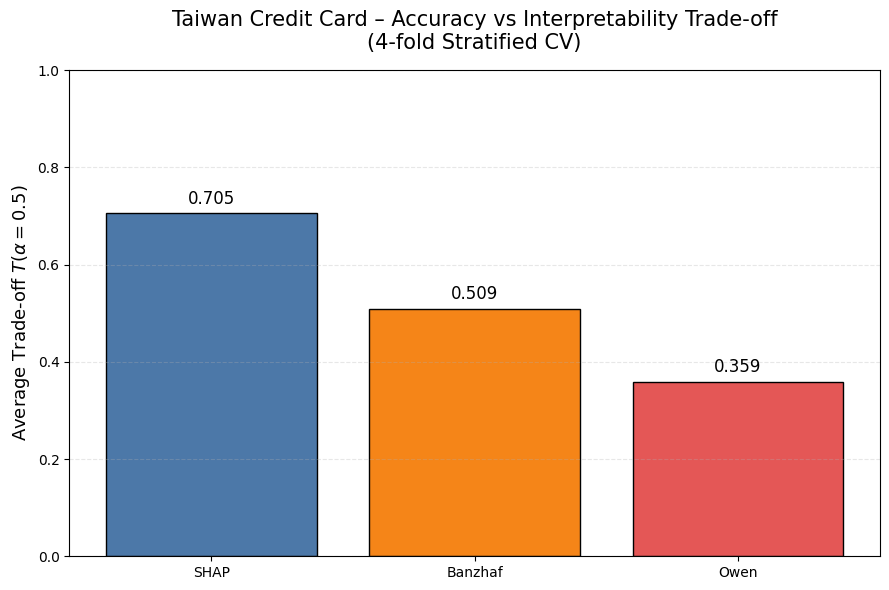

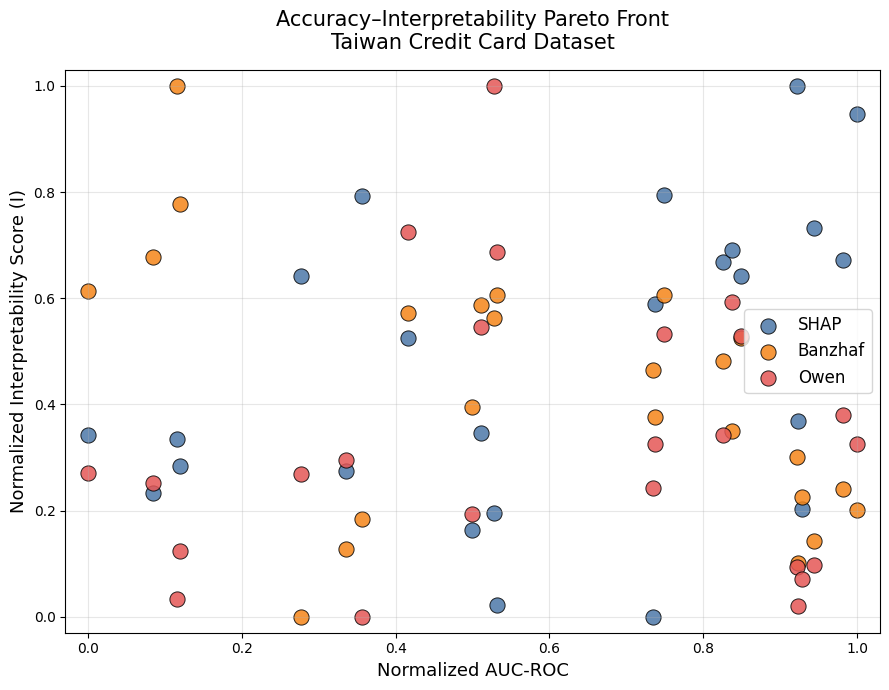

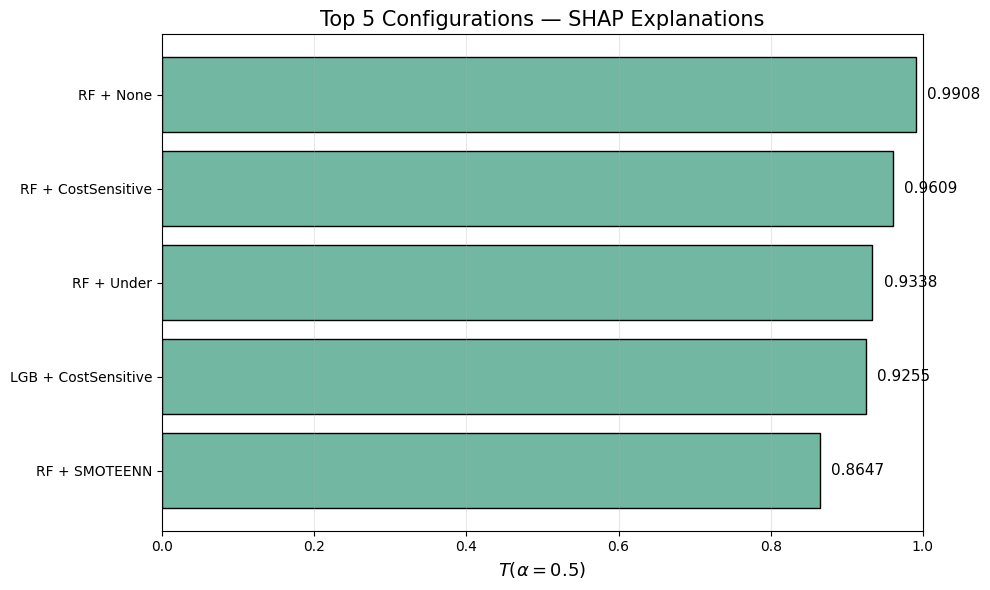

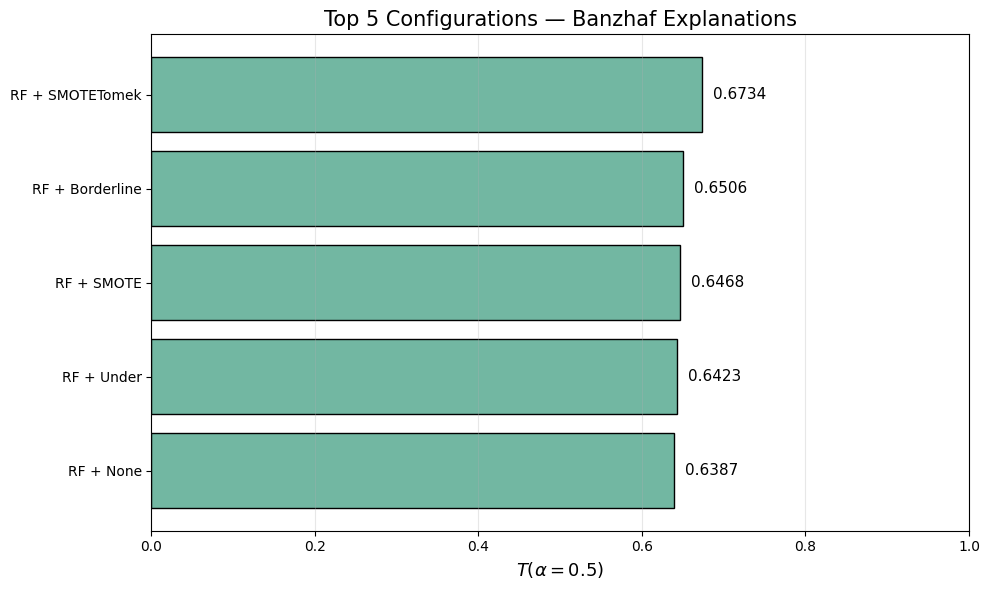

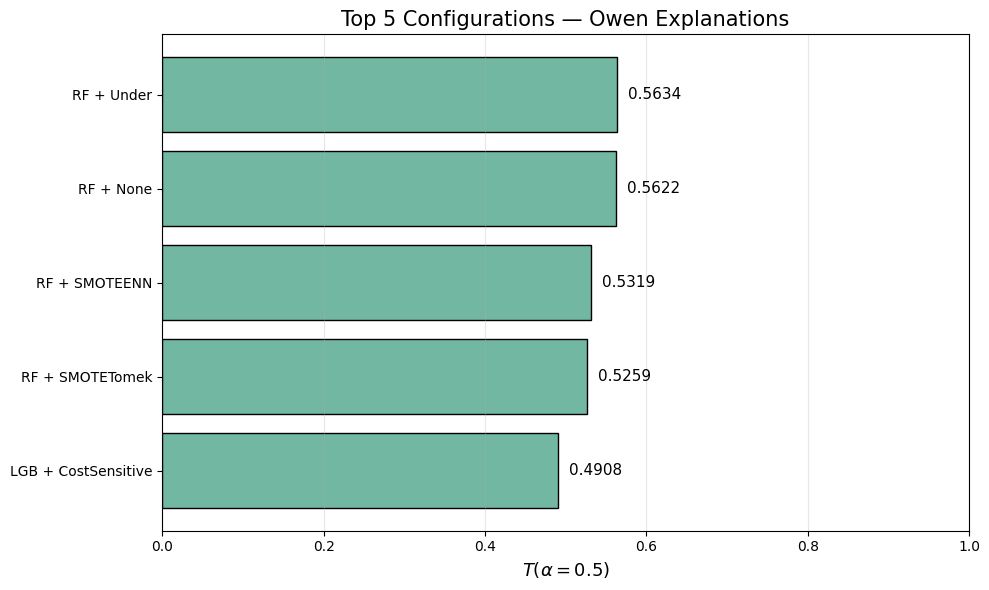

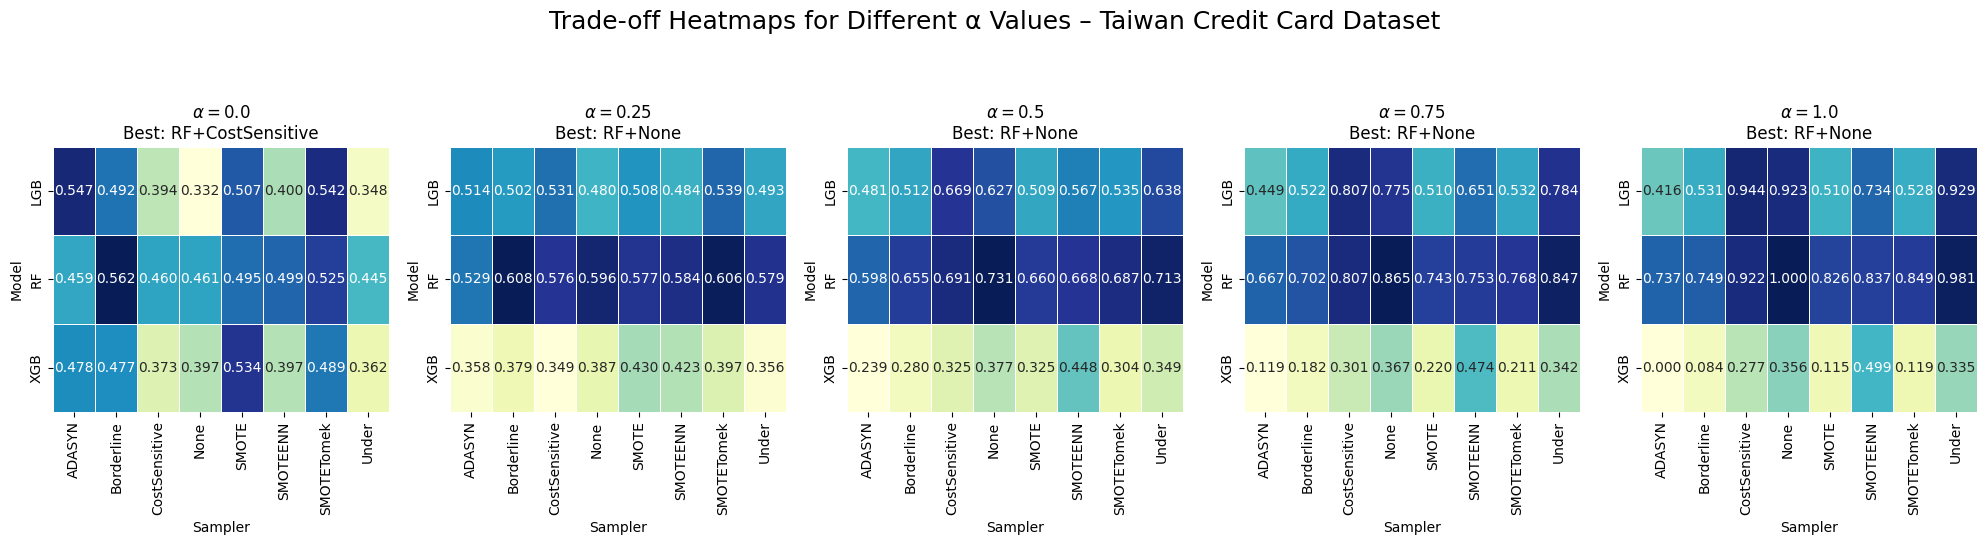

In [ ]:
# ============================================================
# 8. FINAL PLOTS – Thesis-ready (Taiwan Credit Card Dataset)
# ============================================================

# --- Safe normalization function (needed for plots) ---
def safe_normalize(s: pd.Series):
    """Min-max normalize to [0,1] safely"""
    mn, mx = s.min(), s.max()
    if mx == mn:
        return pd.Series(0.5, index=s.index)
    return ((s - mn) / (mx - mn)).clip(0, 1)

# Make sure we work on a copy
metrics = metrics.copy()

# 1. Average Trade-off by Method
plt.figure(figsize=(9, 6))
method_avg = metrics.groupby('Method')['T(α=0.5)'].mean().reindex(['SHAP', 'Banzhaf', 'Owen'])
bars = plt.bar(method_avg.index, method_avg.values,
               color=['#4C78A8', '#F58518', '#E45756'],
               edgecolor='black', linewidth=1)
plt.bar_label(bars, fmt='%.3f', fontsize=12, padding=4)
plt.ylabel("Average Trade-off $T(\\alpha=0.5)$", fontsize=13)
plt.title("Taiwan Credit Card – Accuracy vs Interpretability Trade-off\n(4-fold Stratified CV)", fontsize=15, pad=15)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 2. Accuracy vs Interpretability Scatter (Normalized)
plt.figure(figsize=(9, 7))
colors = {'SHAP': '#4C78A8', 'Banzhaf': '#F58518', 'Owen': '#E45756'}
for method in ['SHAP', 'Banzhaf', 'Owen']:
    sub = metrics[metrics['Method'] == method]
    plt.scatter(safe_normalize(sub['AUC']), safe_normalize(sub['I']),
                s=120, label=method, color=colors[method], alpha=0.85,
                edgecolors='black', linewidth=0.7)

plt.xlabel("Normalized AUC-ROC", fontsize=13)
plt.ylabel("Normalized Interpretability Score (I)", fontsize=13)
plt.title("Accuracy–Interpretability Pareto Front\nTaiwan Credit Card Dataset", fontsize=15, pad=15)
plt.legend(fontsize=12, frameon=True)
plt.grid(alpha=0.3)
plt.xlim(-0.03, 1.03)
plt.ylim(-0.03, 1.03)
plt.tight_layout()
plt.show()

# 3. Top 5 Configurations per Explanation Method
for method in ['SHAP', 'Banzhaf','Owen']:
    plt.figure(figsize=(10, 6))
    top5 = metrics[metrics['Method'] == method].nlargest(5, 'T(α=0.5)')
    labels = [f"{r.Model} + {r.Sampler}" for r in top5.itertuples()]
    values = top5['T(α=0.5)'].round(4)

    bars = plt.barh(labels, values, color='#72B7A2', edgecolor='black')
    plt.bar_label(bars, fmt='%.4f', padding=8, fontsize=11)
    plt.xlabel("$T(\\alpha=0.5)$", fontsize=13)
    plt.title(f"Top 5 Configurations — {method} Explanations", fontsize=15)
    plt.xlim(0, 1)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# 4.  Heatmap of T(α) for different α
plt.figure(figsize=(20, 5))
alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
for i, alpha in enumerate(alphas):
    col = f'T(α={alpha})'
    metrics[col] = alpha * safe_normalize(metrics['AUC']) + (1-alpha) * safe_normalize(metrics['I'])

    plt.subplot(1, 5,i+1)
    heatmap_data = metrics.pivot_table(values=col, index='Model', columns='Sampler', aggfunc='mean')
    sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlGnBu', cbar=False, linewidths=.5)

    best = metrics.loc[metrics[col].idxmax()]
    plt.title(f"$\\alpha = {alpha}$\nBest: {best.Model}+{best.Sampler}", fontsize=12)

plt.suptitle("Trade-off Heatmaps for Different α Values – Taiwan Credit Card Dataset", fontsize=18, y=1.08)
plt.tight_layout()
plt.show()